<a href="https://colab.research.google.com/github/lamyse1/deep-learning-/blob/main/Final%20Project/Copy_of_DL_Final_Project_Diabetes_LamyseAmmar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

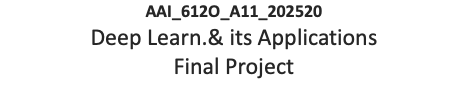

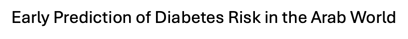

In [41]:
#Install required Libraries
!pip install tensorflow pandas scikit-learn numpy matplotlib seaborn imbalanced-learn xgboost catboost lightgbm


In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization, Input
from tensorflow.keras.layers import Concatenate, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


## Load and Preprocess the dataset

In [43]:
def load_and_preprocess_data(url, column_names):
    df = pd.read_csv(url, names=column_names)

    # Replace zero values with NaN for medical features
    cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

    # KNN Imputation for missing values
    imputer = KNNImputer(n_neighbors=5)
    df[cols_with_zeros] = imputer.fit_transform(df[cols_with_zeros])

    # Feature Engineering
    df['Glucose_to_Insulin'] = df['Glucose'] / (df['Insulin'] + 1)
    df['BMI_Age'] = df['BMI'] * df['Age'] / 100
    df['Glucose_BMI'] = df['Glucose'] * df['BMI'] / 100
    df['BP_Age'] = df['BloodPressure'] * df['Age'] / 100

    # Define Features and Target
    X = df.drop(columns=['Outcome'])
    y = df['Outcome']

    # Data Balancing using SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE)
    X_balanced, y_balanced = smote.fit_resample(X, y)

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_balanced)

    # Reshape for Transformer Model (treat each feature as a sequence)
    X_transformer = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, random_state=RANDOM_STATE, stratify=y_balanced)
    X_transformer_train, X_transformer_test, _, _ = train_test_split(X_transformer, y_balanced, test_size=0.2, random_state=RANDOM_STATE, stratify=y_balanced)

    return X_train, X_test, X_transformer_train, X_transformer_test, y_train, y_test

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
X_train, X_test, X_transformer_train, X_transformer_test, y_train, y_test = load_and_preprocess_data(url, column_names)


## Transformer Model for Tabular Data

In [44]:
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Transformer Block
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Dropout(0.2)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)

    # Global Average Pooling to reduce sequence dimension
    x = GlobalAveragePooling1D()(x)

    # Final Dense layers
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC()])

    return model


## Train and Evaluate the Transformer Model

In [45]:
transformer_model = build_transformer_model((X_train.shape[1], 1))

transformer_history = transformer_model.fit(
    X_transformer_train, y_train, epochs=50, batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

y_pred_transformer = (transformer_model.predict(X_transformer_test) > 0.5).astype(int)
print("\nTransformer Model Performance:")
print(classification_report(y_test, y_pred_transformer))
print(f"AUC-ROC: {roc_auc_score(y_test, transformer_model.predict(X_transformer_test)):.4f}")



Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5094 - auc_2: 0.5000 - loss: 0.6932 - val_accuracy: 0.4812 - val_auc_2: 0.5000 - val_loss: 0.6932
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5094 - auc_2: 0.5000 - loss: 0.6931 - val_accuracy: 0.4812 - val_auc_2: 0.5000 - val_loss: 0.6932
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5094 - auc_2: 0.5000 - loss: 0.6931 - val_accuracy: 0.4812 - val_auc_2: 0.5000 - val_loss: 0.6932
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5094 - auc_2: 0.5000 - loss: 0.6931 - val_accuracy: 0.4812 - val_auc_2: 0.5000 - val_loss: 0.6932
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5094 - auc_2: 0.5000 - loss: 0.6931 - val_accuracy: 0.4812 - val_auc_2: 0.5000 - val_loss: 0.6933
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5094 - auc_2: 0.5000 - loss: 0.6931 - val_accuracy: 0.4812 - val_auc_2: 0.5000 - val_loss: 0.6933
Epoch 7/50
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## LSTM Model with Attention

In [46]:
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)

    attention_output = MultiHeadAttention(key_dim=32, num_heads=2, dropout=0.1)(x, x)
    x = LayerNormalization(epsilon=1e-6)(attention_output + x)

    x = Bidirectional(LSTM(32, return_sequences=False))(x)
    x = Dropout(0.3)(x)

    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC()])

    return model


## Train and Evaluate the LSTM Model

In [47]:
X_lstm_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_lstm_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

lstm_model = build_lstm_model((1, X_train.shape[1]))

lstm_history = lstm_model.fit(
    X_lstm_train, y_train, epochs=50, batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

y_pred_lstm = (lstm_model.predict(X_lstm_test) > 0.5).astype(int)
print("\nLSTM Model Performance:")
print(classification_report(y_test, y_pred_lstm))
print(f"AUC-ROC: {roc_auc_score(y_test, lstm_model.predict(X_lstm_test)):.4f}")



Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6530 - auc_3: 0.7128 - loss: 0.6310 - val_accuracy: 0.7188 - val_auc_3: 0.7999 - val_loss: 0.5582
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7433 - auc_3: 0.8271 - loss: 0.5140 - val_accuracy: 0.7312 - val_auc_3: 0.8137 - val_loss: 0.5370
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7715 - auc_3: 0.8495 - loss: 0.4850 - val_accuracy: 0.7375 - val_auc_3: 0.8174 - val_loss: 0.5181
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7734 - auc_3: 0.8632 - loss: 0.4666 - val_accuracy: 0.7312 - val_auc_3: 0.8244 - val_loss: 0.5297
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7794 - auc_3: 0.8688 - loss: 0.4501 - val_accuracy: 0.7563 - val_auc_3: 0.8305 - val_loss: 0.5138
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7882 - auc_3: 0.8671 - loss: 0.4563 - val_accuracy: 0.7563 - val_auc_3: 0.8366 - val_loss: 0.4994
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step

LSTM Model Performance:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       100
           1       0.79      0.82      0.80       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
AUC-ROC: 0.8742
